In [61]:
!wget https://raw.githubusercontent.com/ducanh2505/recommender_system/master/data.csv

--2020-12-31 15:11:08--  https://raw.githubusercontent.com/ducanh2505/recommender_system/master/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6717789 (6.4M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   6.41M  37.1MB/s    in 0.2s    

2020-12-31 15:11:09 (37.1 MB/s) - ‘data.csv.1’ saved [6717789/6717789]




## Tiền xử lý dữ liệu


### Import các thư viện cần thiết

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
# basic visualization package
import matplotlib.pyplot as plt

In [63]:
### Đọc dữ liệu

df = pd.read_csv('data.csv')




In [64]:
df.shape


(5939, 19)

In [65]:

df.head()


,IMDb,IMDb_votes,director,nations,duration,quality,resolution,language,genres,company,vietnamese_name,name,year,id,star,recommendations,film_content,actors,relase
0,7.0,2828.0,"Joel Crawford,","Mỹ,",95.0,Bản đẹp,Full HD,Phụ đề Việt,"Phim viễn tưởng, Phim phiêu lưu, Phim hài hước...",DreamWorks Animation,Gia Đình Croods: Kỷ Nguyên Mới,The Croods: A New Age,2020,11980,0.00,"['88', '9468', '3389', '11290', '1']",Sinh tồn trong một thế giới tiền sử luôn rình ...,"Nicolas Cage, Emma Stone, Ryan Reynolds, Cathe...",NaN
1,8.2,3065.0,"Tomm Moore, Ross Stewart,","Mỹ, Pháp, Anh, Luxembourg, Denmark, Ireland,",103.0,Bản đẹp,Full HD,Phụ đề Việt,"Phim viễn tưởng, Phim phiêu lưu, Phim gia đình...","Apple Original Films, Cartoon Saloon, Mélusine...",Sói Lang Thang,WolfWalkers,2020,11977,0.00,"['3021', '11115', '10682', '2674', '9923', '25...",Trong một thời kỳ nơi tồn tại đầy dẫy ma thuật...,"Honor Kneafsey, Sean Bean, Simon Mcburney, Mar...",30/10/2020
2,4.3,166.0,"Liming Li,","Trung Quốc,",84.0,Bản đẹp,HD 720p,Thuyết minh,"Phim hành động, Phim võ thuật, Phim hồi hộp-Gâ...",Chưa rõ,Diệp Vấn: Bậc Thầy Võ Thuật,Ip Man: Kung Fu Master,2019,11979,6.03,"['3629', '1204', '9551', '4582', '1', '2']",IP MAN: KUNG FU MASTER quay trở lại những ngày...,"Yu-Hang To, Michael Wong, Wanliruo Xin, Dongfe...",23/12/2019
3,6.2,9881.0,"Ryan Murphy,","Mỹ,",130.0,Bản đẹp,Full HD,Phụ đề Việt,"Phim hài hước, Phim tâm lý, Phim chính kịch - ...","Dramatic Forces, Storykey, Netflix",Vũ Hội Tốt Nghiệp,The Prom,2020,11978,6.11,"['4473', '8663', '9283', '2818', '11302', '11']",Nhóm sao Broadway đang lúc kém vận làm đảo lộn...,"Meryl Streep, James Corden, Nicole Kidman, Ker...",11/12/2020
4,5.8,69.0,"Ming-Lang Chen,","Đài Loan,",92.0,Bản đẹp,Full HD,Phụ đề Việt,"Phim tình cảm-Lãng mạn, Phim chính kịch - Dram...",Swallow Wings,Tâm Hồn Yêu Thương,The Teacher (My Soul Is Made Of Love),2019,11908,5.86,"['6182', '6372', '11889', '5965', '22']","Kevin, một giáo viên Giáo dục công dân 26 tuổi...","Oscar Chiu, Chin-Hao Chang, Tzu-Hua Ho, Winnie...",6/12/2019


In [66]:

df.describe(include='all')

,IMDb,IMDb_votes,director,nations,duration,quality,resolution,language,genres,company,vietnamese_name,name,year,id,star,recommendations,film_content,actors,relase
count,5130.000000,4.081000e+03,5596,5939,5849.000000,5939,5939,5939,5939,5939,5939,5939,5939.000000,5939.000000,5939.000000,5939,5939,5752,3641
unique,NaN,NaN,3695,465,NaN,4,3,8,1378,4085,5867,5867,NaN,NaN,NaN,5843,5930,5733,2268
top,NaN,NaN,"Steven Spielberg,","Mỹ,",NaN,Bản đẹp,Full HD,Phụ đề Việt,"Phim hài hước, Phim lẻ",Chưa rõ,Báo thù,Mulan,NaN,NaN,NaN,"['46', '938', '122', '4077', '4125', '702']","Khi Ayase Chihaya lên lớp 6, cô đã gặp Wataya ...","Minami Takayama, Wakana Yamazaki, Akira Kamiya",25/8/2017
freq,NaN,NaN,16,2140,NaN,5887,3169,4210,188,1104,4,4,NaN,NaN,NaN,5,2,4,10
mean,6.443411,4.247428e+04,NaN,NaN,105.314242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.022563,5450.393332,6.915080,NaN,NaN,NaN,NaN
std,1.068834,1.259093e+05,NaN,NaN,30.695279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.884043,3586.784899,1.040024,NaN,NaN,NaN,NaN
min,2.000000,2.000000e+00,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1940.000000,1.000000,0.000000,NaN,NaN,NaN,NaN
25%,5.800000,2.990000e+02,NaN,NaN,92.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,2251.500000,6.300000,NaN,NaN,NaN,NaN
50%,6.500000,2.631000e+03,NaN,NaN,102.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000,5085.000000,6.860000,NaN,NaN,NaN,NaN
75%,7.200000,2.099200e+04,NaN,NaN,117.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,8459.500000,7.500000,NaN,NaN,NaN,NaN


*vì dữ liệu ở các cột recomendations, vietnamese name, name, ID không ảnh hưởng đến chất lượng của bộ phim nên ta sẽ bỏ qua. Các thuộc tính về actors và director khá là thưa, vì một diễn viên hoặc đạo diễn chỉ góp mặt rất ít bộ phim trên tổng số dữ liệu. Cột quality đã được thể hiện qua cột resolution*

In [67]:
df.columns

Index(['IMDb', 'IMDb_votes', 'director', 'nations', 'duration', 'quality',
       'resolution', 'language', 'genres', 'company', 'vietnamese_name',
       'name', 'year', 'id', 'star', 'recommendations', 'film_content',
       'actors', 'relase'],
      dtype='object')

In [68]:


train_df = df.drop(['recommendations','vietnamese_name','quality',
       'name','actors','director','id','film_content','company','relase'],axis=1)

In [69]:
train_df

,IMDb,IMDb_votes,nations,duration,resolution,language,genres,year,star
0,7.0,2828.0,"Mỹ,",95.0,Full HD,Phụ đề Việt,"Phim viễn tưởng, Phim phiêu lưu, Phim hài hước...",2020,0.00
1,8.2,3065.0,"Mỹ, Pháp, Anh, Luxembourg, Denmark, Ireland,",103.0,Full HD,Phụ đề Việt,"Phim viễn tưởng, Phim phiêu lưu, Phim gia đình...",2020,0.00
2,4.3,166.0,"Trung Quốc,",84.0,HD 720p,Thuyết minh,"Phim hành động, Phim võ thuật, Phim hồi hộp-Gâ...",2019,6.03
3,6.2,9881.0,"Mỹ,",130.0,Full HD,Phụ đề Việt,"Phim hài hước, Phim tâm lý, Phim chính kịch - ...",2020,6.11
4,5.8,69.0,"Đài Loan,",92.0,Full HD,Phụ đề Việt,"Phim tình cảm-Lãng mạn, Phim chính kịch - Dram...",2019,5.86
...,...,...,...,...,...,...,...,...,...
5934,5.9,NaN,"Thái Lan,",138.0,HD 720p,Phụ đề Việt,"Phim tâm lý, Phim lẻ",2013,6.10
5935,6.4,NaN,"Anh,",90.0,HD 720p,Phụ đề Việt,"Phim hành động, Phim chiếu rạp, Phim lẻ",2014,7.33
5936,6.4,NaN,"Mỹ,",86.0,HD 720p,Phụ đề Việt,"Phim phiêu lưu, Phim kinh dị, Phim lẻ",2007,5.70
5937,6.1,9359.0,"Mỹ, Anh, Canada, Đức, Sweden,",117.0,Full HD,Phụ đề việt + Thuyết minh,"Phim hành động, Phim hình sự, Phim hồi hộp-Gây...",2018,7.00


In [70]:
train_df.isna().sum()

IMDb           809
IMDb_votes    1858
nations          0
duration        90
resolution       0
language         0
genres           0
year             0
star             0
dtype: int64

In [71]:
train_df.IMDb.fillna(train_df.IMDb.median(),inplace=True)
train_df.IMDb_votes.fillna(train_df.IMDb_votes.median(),inplace=True)

In [72]:
train_df.dtypes

IMDb          float64
IMDb_votes    float64
nations        object
duration      float64
resolution     object
language       object
genres         object
year            int64
star          float64
dtype: object

### One Hot encoding cột resolution
Từ dữ liệu ban đầu ta sẽ tạo thêm các cột tương ứng với các giá trị trong cột resolution

In [73]:

print(df.resolution.unique())
df.resolution.value_counts()

['Full HD' 'HD 720p' 'SD']


Full HD    3169
HD 720p    2613
SD          157
Name: resolution, dtype: int64

In [74]:
resolution = pd.get_dummies(df.resolution)
resolution.drop(['SD'],axis = 1,inplace =True)
resolution

,Full HD,HD 720p
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0
...,...,...
5934,0,1
5935,0,1
5936,0,1
5937,1,0


In [75]:
train_df = pd.concat([train_df,resolution],axis=1)
train_df.drop(['resolution'],axis=1,inplace=True)
train_df.head()

,IMDb,IMDb_votes,nations,duration,language,genres,year,star,Full HD,HD 720p
0,7.0,2828.0,"Mỹ,",95.0,Phụ đề Việt,"Phim viễn tưởng, Phim phiêu lưu, Phim hài hước...",2020,0.00,1,0
1,8.2,3065.0,"Mỹ, Pháp, Anh, Luxembourg, Denmark, Ireland,",103.0,Phụ đề Việt,"Phim viễn tưởng, Phim phiêu lưu, Phim gia đình...",2020,0.00,1,0
2,4.3,166.0,"Trung Quốc,",84.0,Thuyết minh,"Phim hành động, Phim võ thuật, Phim hồi hộp-Gâ...",2019,6.03,0,1
3,6.2,9881.0,"Mỹ,",130.0,Phụ đề Việt,"Phim hài hước, Phim tâm lý, Phim chính kịch - ...",2020,6.11,1,0
4,5.8,69.0,"Đài Loan,",92.0,Phụ đề Việt,"Phim tình cảm-Lãng mạn, Phim chính kịch - Dram...",2019,5.86,1,0


### Chuyển duration thành kiểu số nguyên 

In [76]:

train_df.duration.unique()

array([  95.,  103.,   84.,  130.,   92.,  120.,  110.,  132.,   90.,
        117.,   87.,  100.,   85.,  101.,   99.,  124.,  102.,   97.,
        105.,   89.,   nan,   93.,   88.,   98.,  125.,  150.,  131.,
         94.,  107.,   74.,   47.,  126.,  118.,  116.,   80.,   40.,
        114.,  104.,  113.,   83.,   91.,  122.,  115.,  149.,  109.,
        141.,  106.,  121.,   81.,  151.,  153.,   59.,  119.,   86.,
         78.,   73.,   96.,  147.,  138.,  129.,   79.,  108.,   68.,
        111.,  140.,  168.,  144.,   82.,  189.,  112.,  123.,   69.,
         62.,  133.,  127.,  134.,   75.,  181.,   72.,  135.,  160.,
         46.,  163.,  169.,   71.,   66.,  137.,  154.,   67.,  156.,
        167.,  170.,  128.,  136.,  143.,  142.,  205.,   49.,   30.,
        174.,   38.,   22.,   76.,   60.,   61.,   65.,   63.,  157.,
         77.,  148.,  152.,   23.,   43.,  155.,  161.,   56.,   58.,
        146.,  188.,   45.,   55.,   20., 1800.,  209.,   51.,    7.,
        159.,  164.,

In [77]:
train_df.duration.fillna(0,inplace=True)


In [78]:

### Xử lý cột language

In [79]:
print(train_df.language.unique())
train_df.language.value_counts()

['Phụ đề Việt' 'Thuyết minh' 'Phụ đề việt + Thuyết minh'
 'Phụ đề việt + Lồng tiếng việt' 'Lồng tiếng Việt'
 'Phụ đề việt + Lồng tiếng việt + Thuyết minh' 'Theo Quốc gia sản xuất'
 'Tiếng Việt']


Phụ đề Việt                                    4210
Phụ đề việt + Thuyết minh                      1266
Thuyết minh                                     276
Lồng tiếng Việt                                  76
Phụ đề việt + Lồng tiếng việt                    74
Phụ đề việt + Lồng tiếng việt + Thuyết minh      29
Theo Quốc gia sản xuất                            6
Tiếng Việt                                        2
Name: language, dtype: int64

In [80]:
languages = train_df.language.apply(lambda x: x.lower().split(" + ")).explode().unique().tolist()
languages

['phụ đề việt',
 'thuyết minh',
 'lồng tiếng việt',
 'theo quốc gia sản xuất',
 'tiếng việt']

In [81]:
labels = np.zeros((len(df),len(languages)))
for i,language in  train_df.language.apply(lambda x: x.lower().split(" + ")).explode().apply(lambda x: languages.index(x)).items():
  labels[i][language] = 1

language_index_df = pd.DataFrame(labels,columns =languages)

In [82]:
train_df = pd.concat([train_df,language_index_df],axis=1)
train_df.drop(['language','theo quốc gia sản xuất'],axis=1,inplace=True)

In [83]:
train_df.head()

,IMDb,IMDb_votes,nations,duration,genres,year,star,Full HD,HD 720p,phụ đề việt,thuyết minh,lồng tiếng việt,tiếng việt
0,7.0,2828.0,"Mỹ,",95.0,"Phim viễn tưởng, Phim phiêu lưu, Phim hài hước...",2020,0.00,1,0,1.0,0.0,0.0,0.0
1,8.2,3065.0,"Mỹ, Pháp, Anh, Luxembourg, Denmark, Ireland,",103.0,"Phim viễn tưởng, Phim phiêu lưu, Phim gia đình...",2020,0.00,1,0,1.0,0.0,0.0,0.0
2,4.3,166.0,"Trung Quốc,",84.0,"Phim hành động, Phim võ thuật, Phim hồi hộp-Gâ...",2019,6.03,0,1,0.0,1.0,0.0,0.0
3,6.2,9881.0,"Mỹ,",130.0,"Phim hài hước, Phim tâm lý, Phim chính kịch - ...",2020,6.11,1,0,1.0,0.0,0.0,0.0
4,5.8,69.0,"Đài Loan,",92.0,"Phim tình cảm-Lãng mạn, Phim chính kịch - Dram...",2019,5.86,1,0,1.0,0.0,0.0,0.0


In [84]:
### Xử lý cột genres

In [85]:
print(train_df.genres.unique())
train_df.genres.value_counts()

['Phim viễn tưởng, Phim phiêu lưu, Phim hài hước, Phim gia đình, Phim hoạt hình, Phim chiếu rạp, Phim lẻ'
 'Phim viễn tưởng, Phim phiêu lưu, Phim gia đình, Phim hoạt hình, Phim lẻ'
 'Phim hành động, Phim võ thuật, Phim hồi hộp-Gây cấn, Phim thuyết minh, Phim lẻ'
 ... 'Phim hành động, Phim kinh dị, Phim hình sự, Phim phiêu lưu, Phim lẻ'
 'Phim cổ trang, Phim tình cảm-Lãng mạn, Phim chính kịch - Drama, Phim chiếu rạp, Phim lẻ'
 'Phim viễn tưởng, Phim phiêu lưu, Phim hài hước, Phim tâm lý, Phim lẻ']


Phim hài hước, Phim lẻ                                                                                              188
Phim kinh dị, Phim lẻ                                                                                               187
Phim tâm lý, Phim lẻ                                                                                                174
Phim hài hước, Phim tình cảm-Lãng mạn, Phim lẻ                                                                      108
Phim hoạt hình, Phim lẻ                                                                                              99
                                                                                                                   ... 
Phim hình sự, Phim tâm lý, Phim chính kịch - Drama, Phim lẻ                                                           1
Phim hành động, Phim viễn tưởng, Phim phiêu lưu, Phim hài hước, Phim chính kịch - Drama, Phim hoạt hình, Phim lẻ      1
Phim hành động, Phim viễn tưởng, Phim ph

In [86]:

genres = train_df.genres.apply(lambda x:x.split(', ')).explode().unique().tolist()
genres

['Phim viễn tưởng',
 'Phim phiêu lưu',
 'Phim hài hước',
 'Phim gia đình',
 'Phim hoạt hình',
 'Phim chiếu rạp',
 'Phim lẻ',
 'Phim hành động',
 'Phim võ thuật',
 'Phim hồi hộp-Gây cấn',
 'Phim thuyết minh',
 'Phim tâm lý',
 'Phim chính kịch - Drama',
 'Phim Thể thao-Âm nhạc',
 'Phim tình cảm-Lãng mạn',
 'Phim tài liệu',
 'Phim hình sự',
 'Phim kinh dị',
 'Phim Bí ẩn-Siêu nhiên',
 'Phim cổ trang',
 'Phim chiến tranh',
 'Phim thần thoại',
 'Phim kinh điển']

In [87]:
labels = np.zeros((len(df),len(genres)))

for i,g in df.genres.apply(lambda x:x.split(', ')).explode().apply(lambda x: genres.index(x)).items():
  labels[i][g] = 1
  
genres_index_df = pd.DataFrame(labels,columns =genres )

genres_index_df.head()

,Phim viễn tưởng,Phim phiêu lưu,Phim hài hước,Phim gia đình,Phim hoạt hình,Phim chiếu rạp,Phim lẻ,Phim hành động,Phim võ thuật,Phim hồi hộp-Gây cấn,Phim thuyết minh,Phim tâm lý,Phim chính kịch - Drama,Phim Thể thao-Âm nhạc,Phim tình cảm-Lãng mạn,Phim tài liệu,Phim hình sự,Phim kinh dị,Phim Bí ẩn-Siêu nhiên,Phim cổ trang,Phim chiến tranh,Phim thần thoại,Phim kinh điển
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
genres_index_df.sum(axis = 0).sort_values(ascending=False)

Phim lẻ                    5939.0
Phim hành động             1820.0
Phim thuyết minh           1737.0
Phim hài hước              1581.0
Phim chiếu rạp             1142.0
Phim kinh dị               1138.0
Phim phiêu lưu             1131.0
Phim viễn tưởng            1018.0
Phim hồi hộp-Gây cấn        892.0
Phim chính kịch - Drama     848.0
Phim hình sự                812.0
Phim tình cảm-Lãng mạn      696.0
Phim tâm lý                 692.0
Phim hoạt hình              671.0
Phim gia đình               434.0
Phim chiến tranh            423.0
Phim Bí ẩn-Siêu nhiên       362.0
Phim tài liệu               334.0
Phim Thể thao-Âm nhạc       223.0
Phim võ thuật               132.0
Phim cổ trang               120.0
Phim kinh điển               62.0
Phim thần thoại              40.0
dtype: float64

In [89]:

train_df = pd.concat([train_df,genres_index_df],axis=1)
train_df.drop(['genres','Phim lẻ'],axis=1,inplace=True)

In [90]:
train_df.head()

,IMDb,IMDb_votes,nations,duration,year,star,Full HD,HD 720p,phụ đề việt,thuyết minh,lồng tiếng việt,tiếng việt,Phim viễn tưởng,Phim phiêu lưu,Phim hài hước,Phim gia đình,Phim hoạt hình,Phim chiếu rạp,Phim hành động,Phim võ thuật,Phim hồi hộp-Gây cấn,Phim thuyết minh,Phim tâm lý,Phim chính kịch - Drama,Phim Thể thao-Âm nhạc,Phim tình cảm-Lãng mạn,Phim tài liệu,Phim hình sự,Phim kinh dị,Phim Bí ẩn-Siêu nhiên,Phim cổ trang,Phim chiến tranh,Phim thần thoại,Phim kinh điển
0,7.0,2828.0,"Mỹ,",95.0,2020,0.00,1,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.2,3065.0,"Mỹ, Pháp, Anh, Luxembourg, Denmark, Ireland,",103.0,2020,0.00,1,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.3,166.0,"Trung Quốc,",84.0,2019,6.03,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.2,9881.0,"Mỹ,",130.0,2020,6.11,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.8,69.0,"Đài Loan,",92.0,2019,5.86,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cột Nations
- Vì số lượng quốc gia ta quan sát được trong tập dữ liệu là khá lớn, lên đến 94 quốc gia do đó việc one hot encoding như những biến categori trước có lẽ sẽ không hợp lý do đó ta sẽ thử gom cụm các quốc gia lại thuật toán Kmean.
-  Ta sử dụng 2 phương pháp ebow và silhouette để có thể tìm ra một số cụm để chia các quốc gia thành các nhãn hợp lý sau đó ta sẽ one hot dữ liệu theo các nhãn này.

In [91]:
train_df.head()

,IMDb,IMDb_votes,nations,duration,year,star,Full HD,HD 720p,phụ đề việt,thuyết minh,lồng tiếng việt,tiếng việt,Phim viễn tưởng,Phim phiêu lưu,Phim hài hước,Phim gia đình,Phim hoạt hình,Phim chiếu rạp,Phim hành động,Phim võ thuật,Phim hồi hộp-Gây cấn,Phim thuyết minh,Phim tâm lý,Phim chính kịch - Drama,Phim Thể thao-Âm nhạc,Phim tình cảm-Lãng mạn,Phim tài liệu,Phim hình sự,Phim kinh dị,Phim Bí ẩn-Siêu nhiên,Phim cổ trang,Phim chiến tranh,Phim thần thoại,Phim kinh điển
0,7.0,2828.0,"Mỹ,",95.0,2020,0.00,1,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.2,3065.0,"Mỹ, Pháp, Anh, Luxembourg, Denmark, Ireland,",103.0,2020,0.00,1,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.3,166.0,"Trung Quốc,",84.0,2019,6.03,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.2,9881.0,"Mỹ,",130.0,2020,6.11,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.8,69.0,"Đài Loan,",92.0,2019,5.86,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
nations = np.unique([s.strip() for s in train_df.nations.apply(lambda x:x.split(',')).explode().unique().tolist()])
nations = np.delete(nations,np.where(nations==''))

In [93]:
def split_and_strip(x):
    return [s.strip() for s in x.split(',')]

labels = np.zeros((len(df),len(nations)+1))
for i,nation in df.nations.apply(split_and_strip).explode().apply(lambda x: np.where(nations==x)[0].item() if x in nations else -1).items():
  labels[i][nation] = 1
labels = np.delete(labels,-1,axis = 1)
nation_index_df = pd.DataFrame(labels,columns =nations )

In [94]:
average_nations = np.round([train_df.drop(['nations'],axis=1)[nation_index_df[nation] == 1].mean() for nation in nations ],2)

In [95]:
wcss=[]
sil=[]
std = StandardScaler()
average_nations = std.fit_transform(average_nations)
for i in range(2,15):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=45)
    clf.fit(average_nations)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(average_nations, labels, metric='euclidean'))
    wcss.append(clf.inertia_)


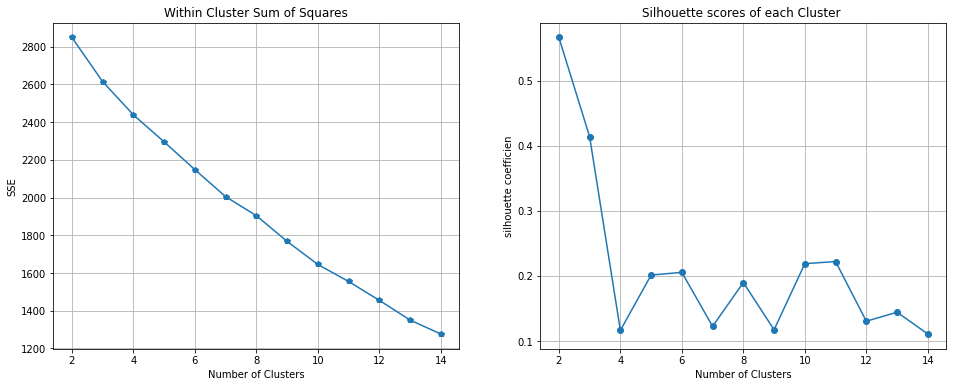

In [96]:
f, ax = plt.subplots(1,2,figsize=(16,6))
x=np.arange(2,15)


ax[0].plot(x,wcss,marker='p')
ax[0].set_title("Within Cluster Sum of Squares")
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel('SSE')
ax[0].grid()



ax[1].plot(x,sil,marker='o')
ax[1].set_title("Silhouette scores of each Cluster ")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel('silhouette coefficien')
ax[1].grid();

$\implies$ Từ biểu đồ ta chọn số lượng cluster cho việc chia các Quốc gia thành các cụm là 4, Tuy ở biểu đồ SSE tại số cụm là 4 không giảm quá nhiều nhưng so với các số lượng cụm các thì số cụm là 4 có silhouette coefficien cao hơn hẳn.

In [97]:
clf=KMeans(n_clusters=4,init='k-means++',random_state=45)
clf.fit(average_nations)
cluster_labels=clf.labels_

In [98]:

clusters = [nations[np.where(x == labels)] for x in range(0,4)]
clusters

[array(['Czech Republic', 'Germany', 'Russia'], dtype='<U23'),
 array(['Bulgaria', 'Cambodia', 'Finland', 'Haiti', 'Hàn Quốc', 'Nga',
        'Thái Lan', 'Ukraine'], dtype='<U23'),
 array(['Austria', 'Azerbaijan', 'Bosnia and Herzegovina', 'Ghana', 'Iran',
        'Latvia', 'Macedonia', 'Senegal', 'Slovenia'], dtype='<U23'),
 array(['Tanzania'], dtype='<U23')]

In [99]:
temp = df.nations.apply(split_and_strip).explode()[df.nations.apply(split_and_strip).explode() != '']
lb = np.zeros((len(train_df),4))
for i,labels in temp.apply(lambda x: cluster_labels[nations.tolist().index(x)]).items():
  lb[i][labels] = 1
lb = np.delete(lb,-1,1)
train_df = pd.concat([train_df,pd.DataFrame(lb)],axis=1)
train_df.drop(['nations'],axis=1,inplace=True)

In [100]:
train_df.head()

,IMDb,IMDb_votes,duration,year,star,Full HD,HD 720p,phụ đề việt,thuyết minh,lồng tiếng việt,tiếng việt,Phim viễn tưởng,Phim phiêu lưu,Phim hài hước,Phim gia đình,Phim hoạt hình,Phim chiếu rạp,Phim hành động,Phim võ thuật,Phim hồi hộp-Gây cấn,Phim thuyết minh,Phim tâm lý,Phim chính kịch - Drama,Phim Thể thao-Âm nhạc,Phim tình cảm-Lãng mạn,Phim tài liệu,Phim hình sự,Phim kinh dị,Phim Bí ẩn-Siêu nhiên,Phim cổ trang,Phim chiến tranh,Phim thần thoại,Phim kinh điển,0,1,2
0,7.0,2828.0,95.0,2020,0.00,1,0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.2,3065.0,103.0,2020,0.00,1,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.3,166.0,84.0,2019,6.03,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6.2,9881.0,130.0,2020,6.11,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.8,69.0,92.0,2019,5.86,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Xây dựng mô hình dự đoán Star

### Chia tập dữ liệu thành 2 phần train và test
- Ta sẽ chia tập train thành 2 tập train và tập valid với tỉ lệ tương ứng là 8:2
- Riêng đối với tập train ta sẽ chia thành 2 tập nhỏ hơn là 1 dùng train 1 dùng để đánh giá (validation) với tỉ lệ tương ứng 7:3

In [101]:
X = train_df.copy().drop(['star'],axis = 1)
Y=  train_df['star']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [103]:
### define các hàm để thể hiện kết quả

In [104]:

rmse_val = []
rmse_train = []
model_names = []

In [105]:
def print_metrics(model,model_name):
  y_train_pred = model.predict(X_train)
  y_val_pred = model.predict(X_val)  
  rmse_val.append(np.sqrt(metrics.mean_squared_error(y_val,y_val_pred)))
  rmse_train.append(np.sqrt(metrics.mean_squared_error(y_train,y_train_pred)))
  model_names.append(model_name)
  print("\t\tError Table of ",model_name) 
  print('Root Mean Squared  Error on train  : ',rmse_train[-1])
  print('Root Mean Squared  Error on val    : ', rmse_val[-1])

### Mô hình Hồi quy tuyến tính

In [106]:
reg_LinearRegression = LinearRegression().fit(X_train, y_train)
print_metrics(reg_LinearRegression,'Linear_Regression')

		Error Table of  Linear_Regression
Root Mean Squared  Error on train  :  0.987019505740694
Root Mean Squared  Error on val    :  0.936774127956401


### Mô hình RidgeCV regression

In [107]:

from sklearn.linear_model import RidgeCV
reg_RidgeCV = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
print_metrics(reg_RidgeCV,'RidgeCV')


		Error Table of  RidgeCV
Root Mean Squared  Error on train  :  0.987174087130796
Root Mean Squared  Error on val    :  0.9369161105492045


### Mô hình ElasticNetCV

In [108]:
from sklearn.linear_model import ElasticNetCV
reg_ElasticNetCV = ElasticNetCV(cv=10).fit(X_train, y_train)
print_metrics(reg_ElasticNetCV,'ElasticNetCV')


		Error Table of  ElasticNetCV
Root Mean Squared  Error on train  :  1.0481608352684457
Root Mean Squared  Error on val    :  1.0008353647814945



### Mô hình LarsCV

In [109]:

from sklearn.linear_model import LarsCV
reg_LarsCV = LarsCV(cv=10).fit(X_train, y_train)
print_metrics(reg_LarsCV,'LarsCV')


		Error Table of  LarsCV
Root Mean Squared  Error on train  :  0.9876789091406428
Root Mean Squared  Error on val    :  0.9376514827046906


### Mô hình LassoCV

In [110]:
from sklearn.linear_model import LassoCV
reg_LassoCV = LassoCV(cv=10).fit(X_train, y_train)
print_metrics(reg_LassoCV,'LassoCV')

		Error Table of  LassoCV
Root Mean Squared  Error on train  :  1.0481608352684457
Root Mean Squared  Error on val    :  1.0008353647814918


### Mô hình OrthogonalMatchingPursuitCV

In [111]:
from sklearn.linear_model import OrthogonalMatchingPursuitCV
reg_OrthogonalMatchingPursuitCV = OrthogonalMatchingPursuitCV(cv=10).fit(X_train, y_train)
print_metrics(reg_OrthogonalMatchingPursuitCV,'OrthogonalMatchingPursuitCV')

		Error Table of  OrthogonalMatchingPursuitCV
Root Mean Squared  Error on train  :  1.0058111521197286
Root Mean Squared  Error on val    :  0.9598223713142126


### Mô hình ARDRegression

In [112]:

from sklearn.linear_model import ARDRegression
reg_ARDRegression = ARDRegression().fit(X_train, y_train)
print_metrics(reg_ARDRegression,'ARDRegression')

		Error Table of  ARDRegression
Root Mean Squared  Error on train  :  0.9897434461911501
Root Mean Squared  Error on val    :  0.9409158461602398



### Mô hình BayesianRidge

In [113]:
from sklearn.linear_model import BayesianRidge
reg_BayesianRidge = BayesianRidge().fit(X_train, y_train)
print_metrics(reg_BayesianRidge,'BayesianRidge')

		Error Table of  BayesianRidge
Root Mean Squared  Error on train  :  0.9884667775969803
Root Mean Squared  Error on val    :  0.935661012157632


### Mô hình HuberRegressor

In [114]:

from sklearn.linear_model import HuberRegressor
reg_HuberRegressor = HuberRegressor().fit(X_train, y_train)
print_metrics(reg_HuberRegressor,'HuberRegressor')


		Error Table of  HuberRegressor
Root Mean Squared  Error on train  :  1.050331234261988
Root Mean Squared  Error on val    :  1.0040280497179324



### Mô hình RANSACRegressor

In [115]:
from sklearn.linear_model import RANSACRegressor
reg_RANSACRegressor = RANSACRegressor().fit(X_train, y_train)
print_metrics(reg_RANSACRegressor,'RANSACRegressor')

		Error Table of  RANSACRegressor
Root Mean Squared  Error on train  :  1.205572930447388
Root Mean Squared  Error on val    :  1.182577244081644


### Mô hình TheilSenRegressor

In [116]:


from sklearn.linear_model import TheilSenRegressor
reg_TheilSenRegressor = TheilSenRegressor().fit(X_train, y_train)
print_metrics(reg_TheilSenRegressor,'TheilSenRegressor')

		Error Table of  TheilSenRegressor
Root Mean Squared  Error on train  :  1.1283932420069243
Root Mean Squared  Error on val    :  1.079164462164822


### Mô hình RandomForestRegressor

In [117]:

from sklearn.ensemble import RandomForestRegressor
reg_RandomForestRegressor = RandomForestRegressor().fit(X_train, y_train)
print_metrics(reg_RandomForestRegressor,'RandomForestRegressor')

		Error Table of  RandomForestRegressor
Root Mean Squared  Error on train  :  0.37721906510021347
Root Mean Squared  Error on val    :  0.9388997159920376


### Mô hình SVM


In [118]:
from sklearn.svm import SVR
reg_SVR = SVR().fit(X_train, y_train)
print_metrics(reg_SVR,'SVR')


		Error Table of  SVR
Root Mean Squared  Error on train  :  1.0476265941802236
Root Mean Squared  Error on val    :  1.0014511094870537


### So sánh các mô hình

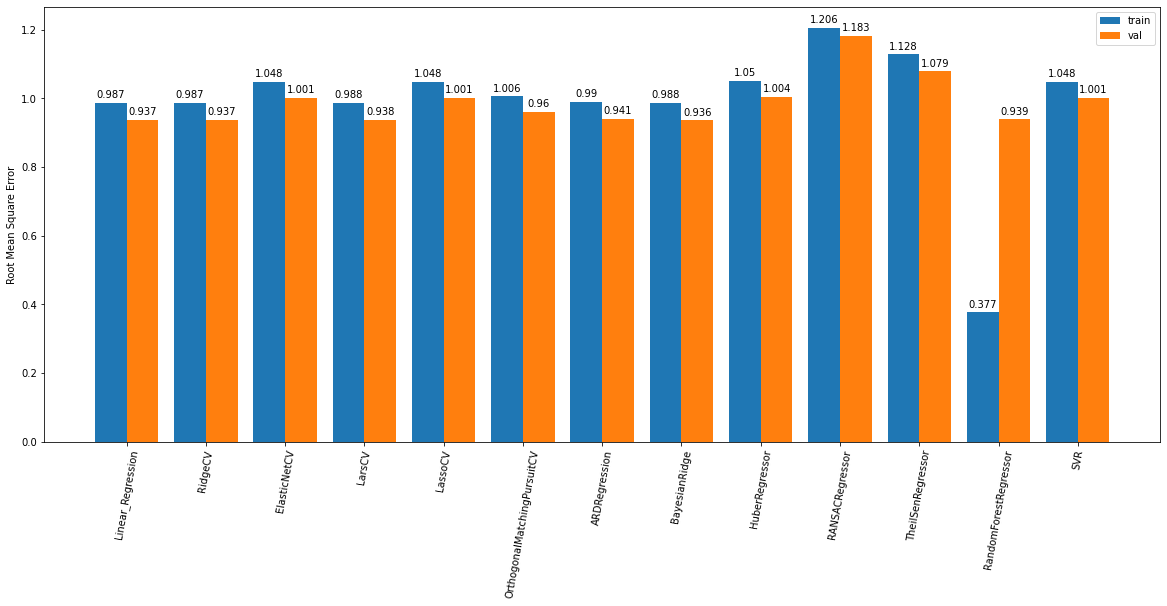

In [119]:


x = np.arange(len(model_names)) 
width = 0.4 # the width of the bars

fig, ax = plt.subplots(figsize=(20,8))
rects1 = ax.bar(x - width/2,np.round(rmse_train,3), width, label='train')
rects2 = ax.bar(x + width/2, np.round(rmse_val,3), width, label='val')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Root Mean Square Error')
ax.set_xticks(x)
ax.set_xticklabels(model_names,rotation=80)

ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical 
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)


$\implies$ các mô hình tuyến tính cho kêt quả tốt hơn so với các mô hình như SVM hay randomforest vì dữ liệu chưa đủ lớn. Đặc biệt randomforest cho kết quả overfitting

### Kết quả
với biểu đồ trên ta sẽ sử dụng mô hình RidgeCV để dự đoán trên tập test

In [124]:
y_test_pred = reg_RidgeCV.predict(X_test)
print('RMSEon test set: ',np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))


RMSEon test set:  0.9905173749812054
